<a target="_blank" href="https://colab.research.google.com/github/TransformerLensOrg/TransformerLens/blob/main/demos/Grokking_Demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Grokking Demo Notebook

<b style="color: red">To use this notebook, go to Runtime > Change Runtime Type and select GPU as the hardware accelerator.</b>

# Setup
(No need to read)

In [1]:
TRAIN_MODEL = True

In [2]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
import os

DEVELOPMENT_MODE = True
IN_GITHUB = os.getenv("GITHUB_ACTIONS") == "true"
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")

    # PySvelte is an unmaintained visualization library, use it as a backup if circuitsvis isn't working
    # # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

if IN_COLAB or IN_GITHUB:
    %pip install transformer_lens
    %pip install circuitsvis

Running as a Colab notebook
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.2/189.2 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 993.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/

In [3]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: colab


In [4]:
pio.templates['plotly'].layout.xaxis.title.font.size = 20
pio.templates['plotly'].layout.yaxis.title.font.size = 20
pio.templates['plotly'].layout.title.font.size = 30

In [5]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import os
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [6]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


Plotting helper functions:

In [7]:
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

In [8]:
# Define the location to save the model, using a relative path
PTH_LOCATION = "workspace/_scratch/grokking_demo.pth"

# Create the directory if it does not exist
os.makedirs(Path(PTH_LOCATION).parent, exist_ok=True)

# Model Training

## Config

In [9]:
p = 10
frac_train = 0.72

# Optimizer config
lr = 1e-3
wd = 1.
betas = (0.9, 0.98)

num_epochs = 5000
checkpoint_every = 100

DATA_SEED = 598

## Define Task
* Define generalized Fibonacci
* Define the dataset & labels

Input format:
|a|b|=|

In [10]:
a_vector = einops.repeat(torch.arange(p), "i -> (i j)", j=p)
b_vector = einops.repeat(torch.arange(p), "j -> (i j)", i=p)
equals_vector = einops.repeat(torch.tensor(p), " -> (i j)", i=p, j=p)

In [11]:
dataset = torch.stack([a_vector, b_vector, equals_vector], dim=1).to(device)

In [12]:
labels = (dataset[:, 0] + dataset[:, 1])

Convert this to a train + test set - 30% in the training set

In [13]:
torch.manual_seed(DATA_SEED)
indices = torch.randperm(p*p)
cutoff = int(p*p*frac_train)
train_indices = indices[:cutoff]
test_indices = indices[cutoff:]

train_data = dataset[train_indices]
train_labels = labels[train_indices]
test_data = dataset[test_indices]
test_labels = labels[test_indices]
print(train_data[:5])
print(train_labels[:5])
print(train_data.shape)
print(test_data[:5])
print(test_labels[:5])
print(test_data.shape)

tensor([[ 9,  9, 10],
        [ 7,  7, 10],
        [ 0,  3, 10],
        [ 7,  5, 10],
        [ 6,  2, 10]], device='cuda:0')
tensor([18, 14,  3, 12,  8], device='cuda:0')
torch.Size([72, 3])
tensor([[ 4,  3, 10],
        [ 2,  2, 10],
        [ 4,  1, 10],
        [ 9,  3, 10],
        [ 9,  1, 10]], device='cuda:0')
tensor([ 7,  4,  5, 12, 10], device='cuda:0')
torch.Size([28, 3])


## Define Model

In [14]:

cfg = HookedTransformerConfig(
    n_layers = 1,
    n_heads = 4,
    d_model = 128,
    d_head = 32,
    d_mlp = 512,
    act_fn = "relu",
    normalization_type=None,
    d_vocab=p+1,
    d_vocab_out=2*p,
    n_ctx=3,
    init_weights=True,
    device=device,
    seed = 999,
)

In [15]:
model = HookedTransformer(cfg)

Disable the biases, as we don't need them for this task and it makes things easier to interpret.

In [16]:
for name, param in model.named_parameters():
    if "b_" in name:
        param.requires_grad = False


## Define Optimizer + Loss

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd, betas=betas)

In [18]:
def loss_fn(logits, labels):
    if len(logits.shape)==3:
        logits = logits[:, -1]
    logits = logits.to(torch.float64)
    log_probs = logits.log_softmax(dim=-1)
    correct_log_probs = log_probs.gather(dim=-1, index=labels[:, None])[:, 0]
    return -correct_log_probs.mean()
train_logits = model(train_data)
train_loss = loss_fn(train_logits, train_labels)
print(train_loss)
test_logits = model(test_data)
test_loss = loss_fn(test_logits, test_labels)
print(test_loss)

tensor(3.0037, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)
tensor(3.0052, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward0>)


In [19]:
print("Uniform loss:")
print(np.log(2*p))

Uniform loss:
2.995732273553991


## Actually Train

**Weird Decision:** Training the model with full batch training rather than stochastic gradient descent. We do this so to make training smoother and reduce the number of slingshots.

In [20]:
train_losses = []
test_losses = []
model_checkpoints = []
checkpoint_epochs = []
if TRAIN_MODEL:
    for epoch in tqdm.tqdm(range(num_epochs)):
        train_logits = model(train_data)
        train_loss = loss_fn(train_logits, train_labels)
        train_loss.backward()
        train_losses.append(train_loss.item())

        optimizer.step()
        optimizer.zero_grad()

        with torch.inference_mode():
            test_logits = model(test_data)
            test_loss = loss_fn(test_logits, test_labels)
            test_losses.append(test_loss.item())

        if ((epoch+1)%checkpoint_every)==0:
            checkpoint_epochs.append(epoch)
            model_checkpoints.append(copy.deepcopy(model.state_dict()))
            print(f"Epoch {epoch} Train Loss {train_loss.item()} Test Loss {test_loss.item()}")

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 99 Train Loss 0.012680745224860072 Test Loss 2.252820334350945
Epoch 199 Train Loss 0.0030694291770140547 Test Loss 2.201631673191667
Epoch 299 Train Loss 0.0009109232829262125 Test Loss 2.4108012559228023
Epoch 399 Train Loss 0.00028718996926691703 Test Loss 2.8800600742546014
Epoch 499 Train Loss 9.314425287906002e-05 Test Loss 3.5292027179222427
Epoch 599 Train Loss 3.0312356373596568e-05 Test Loss 4.243093069433012
Epoch 699 Train Loss 1.009818705478531e-05 Test Loss 4.949564873037585
Epoch 799 Train Loss 3.5023730099960895e-06 Test Loss 5.479914898852605
Epoch 899 Train Loss 1.2544038972050725e-06 Test Loss 5.851837775413437
Epoch 999 Train Loss 4.774359315338168e-07 Test Loss 6.043541003541973
Epoch 1099 Train Loss 1.983185786534024e-07 Test Loss 6.119079885914642
Epoch 1199 Train Loss 9.570968809905441e-08 Test Loss 6.092073920064239
Epoch 1299 Train Loss 5.290996087899057e-08 Test Loss 5.977527668951613
Epoch 1399 Train Loss 3.492785341563614e-08 Test Loss 5.8204265518522

In [21]:
torch.save(
    {
        "model":model.state_dict(),
        "config": model.cfg,
        "checkpoints": model_checkpoints,
        "checkpoint_epochs": checkpoint_epochs,
        "test_losses": test_losses,
        "train_losses": train_losses,
        "train_indices": train_indices,
        "test_indices": test_indices,
    },
    PTH_LOCATION)

In [22]:
if not TRAIN_MODEL:
    cached_data = torch.load(PTH_LOCATION)
    model.load_state_dict(cached_data['model'])
    model_checkpoints = cached_data["checkpoints"]
    checkpoint_epochs = cached_data["checkpoint_epochs"]
    test_losses = cached_data['test_losses']
    train_losses = cached_data['train_losses']
    train_indices = cached_data["train_indices"]
    test_indices = cached_data["test_indices"]

## Show Model Training Statistics, Check that it groks!

In [23]:
%pip install git+https://github.com/neelnanda-io/neel-plotly.git
from neel_plotly.plot import line

  Cloning https://github.com/neelnanda-io/neel-plotly.git to /tmp/pip-req-build-trq230fb
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/neel-plotly.git /tmp/pip-req-build-trq230fb
  Resolved https://github.com/neelnanda-io/neel-plotly.git to commit 6dc24b26f8dec991908479d7445dae496b3430b7
  Preparing metadata (setup.py) ... done
  Created wheel for neel_plotly: filename=neel_plotly-0.0.0-py3-none-any.whl size=10188 sha256=1134c934ab4b8a6061b947995edb67310650685fd387017cc5d64ed8729d3a83
  Stored in directory: /tmp/pip-ephem-wheel-cache-7_jhp560/wheels/8b/67/f8/8a94ccda37eea5ac48d867ea4bfa87a4431501b03cfe31f7c2
Successfully built neel_plotly


In [24]:
line([train_losses[::100], test_losses[::100]], x=np.arange(0, len(train_losses), 100), xaxis="Epoch", yaxis="Loss", log_y=True, title="Training Curve for Fibonacci", line_labels=['train', 'test'], toggle_x=True, toggle_y=True)

# Analysing the Model

## Standard Things to Try

In [25]:
original_logits, cache = model.run_with_cache(dataset)
print(original_logits.numel())

6000


Get key weight matrices:

In [26]:
W_E = model.embed.W_E[:-1]
print("W_E", W_E.shape)
W_neur = W_E @ model.blocks[0].attn.W_V @ model.blocks[0].attn.W_O @ model.blocks[0].mlp.W_in
print("W_neur", W_neur.shape)
W_logit = model.blocks[0].mlp.W_out @ model.unembed.W_U
print("W_logit", W_logit.shape)

W_E torch.Size([10, 128])
W_neur torch.Size([4, 10, 512])
W_logit torch.Size([512, 20])


In [27]:
original_loss = loss_fn(original_logits, labels).item()
print("Original Loss:", original_loss)

Original Loss: 6.672079636034114e-08


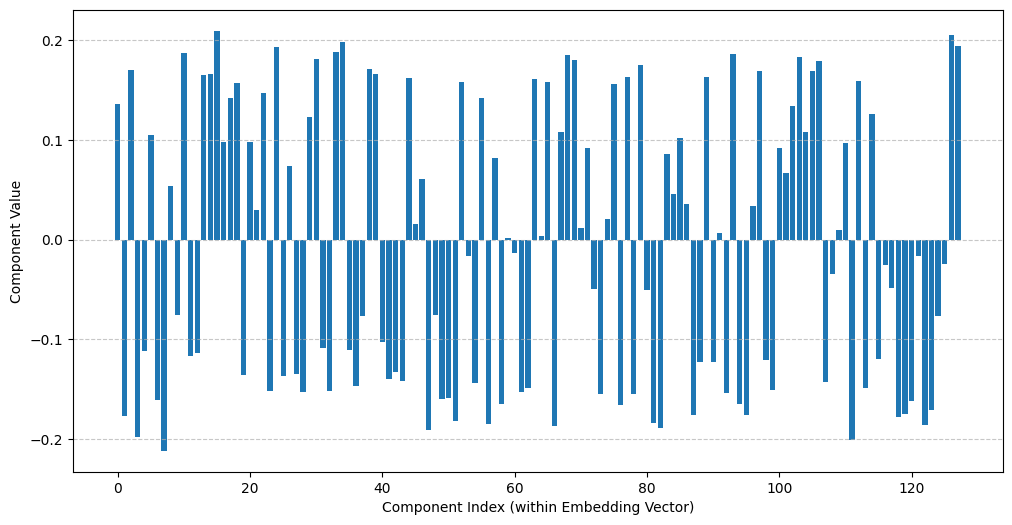

In [28]:
input_number = 7
embedding_vector_np = W_E[input_number].detach().cpu().numpy() # this gets us the embedded vector for input_number

# first we try to plot directly the value of the entries of the embedded vector
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6)) # Adjust figure size as needed
plt.bar(np.arange(128), embedding_vector_np)
plt.xlabel("Component Index (within Embedding Vector)")
plt.ylabel("Component Value")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

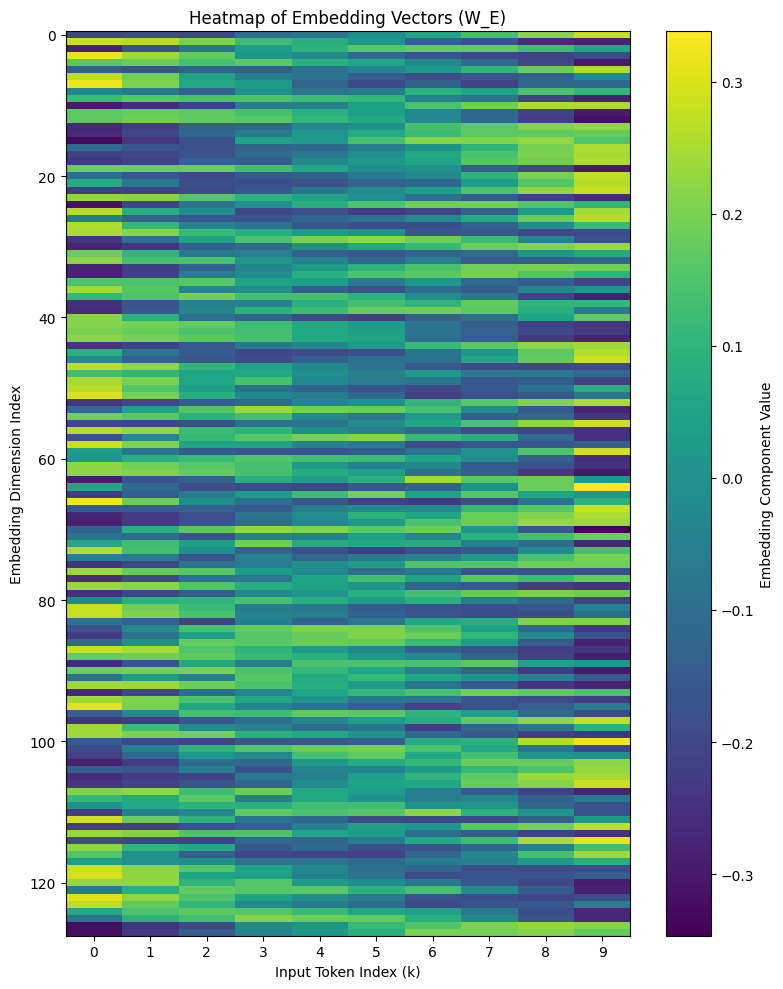

In [29]:
# now we will do a heatmap of the embedded vector for all possible inputs

# We want dimensions along y-axis and inputs along x-axis,
# so we need to transpose the matrix for imshow
W_E_transposed = W_E.detach().cpu().numpy().T # Shape (d, N)

# Get N and d from the original tensor shape
N_vocab = W_E.shape[0]
d_embed = W_E.shape[1]

# Create the heatmap
plt.figure(figsize=(8, 10)) # Adjust figsize as needed (width, height)
# Use imshow to display the matrix as an image.
# aspect='auto' allows the cells to be non-square to fit the plot area.
# interpolation='nearest' avoids blurring pixels.
# cmap='viridis' is a common colormap, change if you prefer another.
im = plt.imshow(W_E_transposed, aspect='auto', interpolation='nearest', cmap='viridis')

# Add labels and title|
plt.xlabel("Input Token Index (k)")
plt.ylabel("Embedding Dimension Index")
plt.title("Heatmap of Embedding Vectors (W_E)")

# Set ticks to match indices
# Show ticks for every input token if N is small
if N_vocab <= 20: # Adjust threshold as needed
     plt.xticks(ticks=np.arange(N_vocab), labels=np.arange(N_vocab))
else:
    # For larger N, show fewer ticks to avoid clutter
     plt.xticks(ticks=np.linspace(0, N_vocab-1, num=min(N_vocab, 10), dtype=int))


# Add a colorbar to show the mapping from color to value
plt.colorbar(im, label='Embedding Component Value')

# Ensure layout is tight
plt.tight_layout()

# Show the plot
plt.show()

It looks... kind of periodic? Let's now try to do PCA (or SVD) on this and see if we can learn anything.

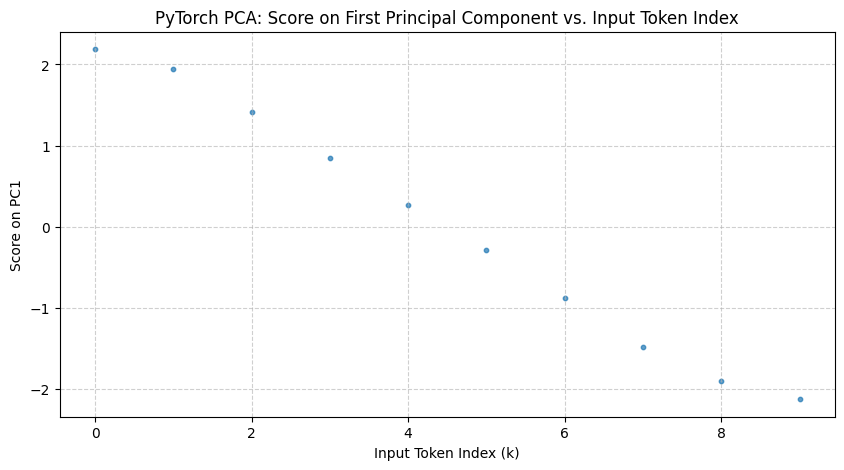

In [30]:
# 1. Center the data (subtract the mean of each dimension)
W_E_mean = W_E.mean(dim=0, keepdim=True) # Calculate mean across samples (N) for each dimension (d)
W_E_centered = W_E - W_E_mean # Broadcasting subtracts the mean from each row

# 2. Perform SVD on the centered data
# U shape: (N, K), S shape: (K,), Vt shape: (K, d) where K = min(N, d)
# full_matrices=False is generally more efficient
U, S, Vt = torch.linalg.svd(W_E_centered, full_matrices=False)

# --- Results ---

# PCA Scores (Data projected onto principal components):
# This is often the primary result needed for visualization/dimensionality reduction.
# It represents each original sample (row in W_E) in the new PCA coordinate system.
pca_scores = U * S  # Shape: (N, K) - Scales the left singular vectors by singular values

# Principal Components (Loadings / Directions of maximum variance):
# These are the rows of Vt. Each row is a d-dimensional vector representing a principal direction.
principal_components = Vt # Shape: (K, d)

# Explained Variance Ratio (requires a bit more calculation):
explained_variance = S.square() / (W_E.shape[0] - 1) # Variance explained by each component
total_variance = explained_variance.sum()
explained_variance_ratio = explained_variance / total_variance

# Plot score on PC1 vs token index k (similar to previous PCA example)
plt.figure(figsize=(10, 5))
plt.scatter(np.arange(W_E.shape[0]), pca_scores[:, 0].detach().cpu().numpy(), alpha=0.7, s=10)
plt.xlabel("Input Token Index (k)")
plt.ylabel("Score on PC1")
plt.title("PyTorch PCA: Score on First Principal Component vs. Input Token Index")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



We observe that the principal component is linear, i.e., the model learns an embedding that is given by embedded_value = w * value + b, with value being the input token index. w is actually negative, and b is ~2.

We now wish to investigate how important this first component, which is a linear function of the inputs, is in comparison with the other components. We do this by looking at how much variance is explained by each of the components.

Explained Variance Ratio by Principal Component:
  PC1: 0.7247 (72.47%) 	| Cumulative: 0.7247 (72.47%)
  PC2: 0.2528 (25.28%) 	| Cumulative: 0.9775 (97.75%)
  PC3: 0.0132 (1.32%) 	| Cumulative: 0.9907 (99.07%)
  PC4: 0.0071 (0.71%) 	| Cumulative: 0.9977 (99.77%)
  PC5: 0.0013 (0.13%) 	| Cumulative: 0.9990 (99.90%)
  PC6: 0.0007 (0.07%) 	| Cumulative: 0.9997 (99.97%)
  PC7: 0.0001 (0.01%) 	| Cumulative: 0.9999 (99.99%)
  PC8: 0.0001 (0.01%) 	| Cumulative: 0.9999 (99.99%)
  PC9: 0.0001 (0.01%) 	| Cumulative: 1.0000 (100.00%)
  PC10: 0.0000 (0.00%) 	| Cumulative: 1.0000 (100.00%)


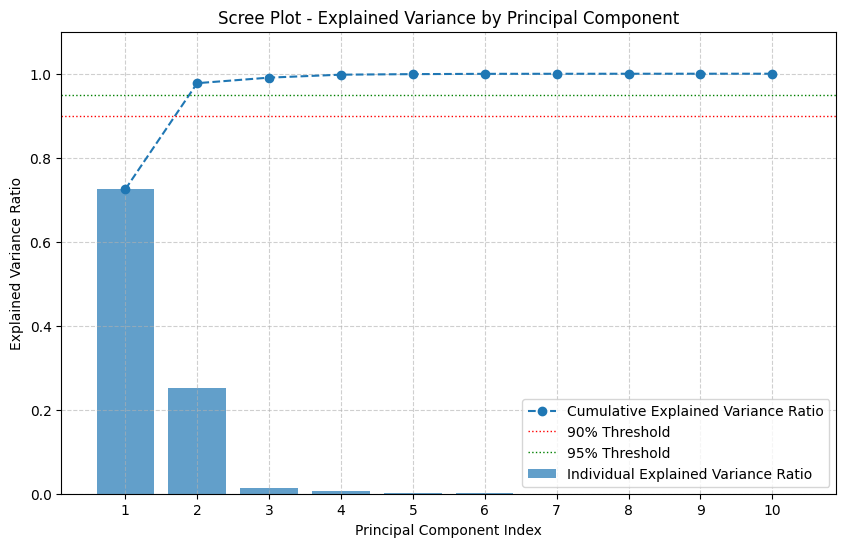

In [31]:
# --- Calculate Explained Variance (using PyTorch SVD results S) ---

# Variance explained by each component (proportional to singular value squared)
# Using N (W_E.shape[0]) instead of N-1 is fine for the ratio calculation
explained_variance = S.square() / W_E.shape[0] # Variance = (singular value / sqrt(N))^2
total_variance = explained_variance.sum()
explained_variance_ratio = explained_variance / total_variance

# Convert to numpy for printing/plotting if needed
explained_variance_ratio_np = explained_variance_ratio.detach().cpu().numpy()

# --- Print the Ratios ---
print(f"Explained Variance Ratio by Principal Component:")
# Limit printing to the number of components computed or a reasonable max (e.g., 10)
num_components_to_print = min(len(explained_variance_ratio_np), 10)
cumulative_variance = 0.0
for i in range(num_components_to_print):
    ratio = explained_variance_ratio_np[i]
    cumulative_variance += ratio
    print(f"  PC{i+1}: {ratio:.4f} ({ratio*100:.2f}%) \t| Cumulative: {cumulative_variance:.4f} ({cumulative_variance*100:.2f}%)")

# If you computed more components than printed:
if len(explained_variance_ratio_np) > num_components_to_print:
    print(f"  ...")
    print(f"Total Cumulative Variance (all {len(explained_variance_ratio_np)} components): {explained_variance_ratio_np.sum():.4f} ({explained_variance_ratio_np.sum()*100:.2f}%)")


# --- Visualize with a Scree Plot ---
plt.figure(figsize=(10, 6))

component_indices = np.arange(1, len(explained_variance_ratio_np) + 1)

# Plot individual explained variance ratios
plt.bar(component_indices, explained_variance_ratio_np, alpha=0.7, align='center',
        label='Individual Explained Variance Ratio')

# Plot cumulative explained variance ratio
cumulative_variance_ratio_np = np.cumsum(explained_variance_ratio_np)
plt.plot(component_indices, cumulative_variance_ratio_np, marker='o', linestyle='--',
         label='Cumulative Explained Variance Ratio')

# Add threshold lines (optional, but common)
plt.axhline(y=0.9, color='r', linestyle=':', linewidth=1, label='90% Threshold')
plt.axhline(y=0.95, color='g', linestyle=':', linewidth=1, label='95% Threshold')


plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot - Explained Variance by Principal Component')
# Ensure x-axis ticks match component indices if not too many
if len(component_indices) <= 15:
    plt.xticks(ticks=component_indices)
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, 1.1) # Set y-axis limit slightly above 1.0
plt.show()

We observe that the first component explains ~0.75 of the variance, and the second component ~0.25. The others are basically irrelevant. This does however mean that we also need to look at the second component to understand what is happening with the embedding. Let us do so now.

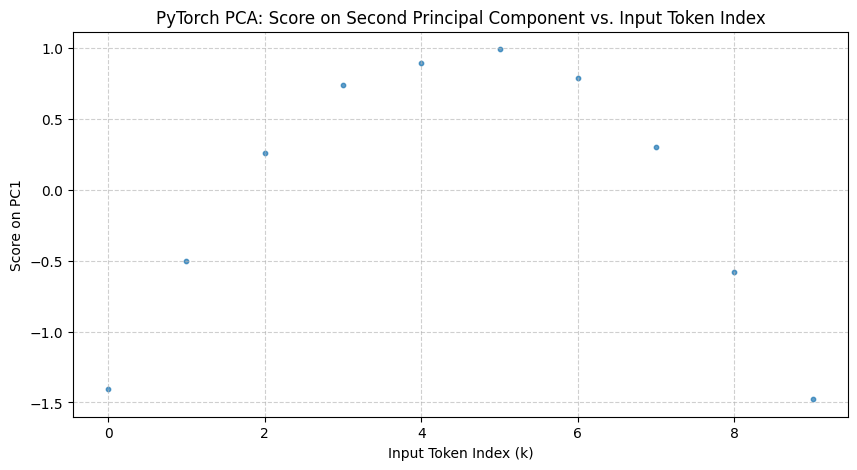

In [32]:
# Plot score on PC2 vs token index k
# This is basically the same code as before, but we now plot the second component rather than the first one
plt.figure(figsize=(10, 5))
plt.scatter(np.arange(W_E.shape[0]), pca_scores[:, 1].detach().cpu().numpy(), alpha=0.7, s=10)
plt.xlabel("Input Token Index (k)")
plt.ylabel("Score on PC1")
plt.title("PyTorch PCA: Score on Second Principal Component vs. Input Token Index")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

This looks like a parabola. I have no clue why! Let's plot below the scores on the first component against the scores on the second component.



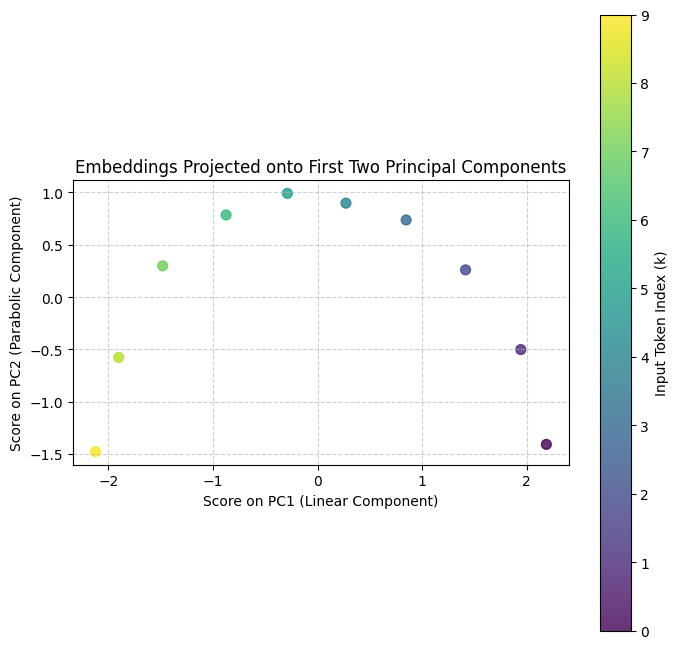

In [33]:
plt.figure(figsize=(8, 8))
token_indices = np.arange(p)
scatter = plt.scatter(
    pca_scores[:, 0].detach().cpu().numpy(),  # X-coordinates are scores on PC1
    pca_scores[:, 1].detach().cpu().numpy(),  # Y-coordinates are scores on PC2
    c=token_indices,                          # Color points based on the input token index (0-9)
    cmap='viridis',                           # Colormap (e.g., 'viridis', 'plasma')
    alpha=0.8,
    s=50                                      # Increase point size for visibility
)
plt.xlabel("Score on PC1 (Linear Component)")
plt.ylabel("Score on PC2 (Parabolic Component)")
plt.title("Embeddings Projected onto First Two Principal Components")
plt.colorbar(scatter, label='Input Token Index (k)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().set_aspect('equal', adjustable='box') # Try to keep scales comparable

An attempt at a conclusion regarding the model's learned embedding:

The model projects inputs (numbers 0-9) onto a low-dimensional (2D) manifold within the embedding space. This representation encodes the number's value primarily along one linear axis (PC1) and secondarily along an orthogonal parabolic axis (PC2). This specific geometric arrangement is likely learned to facilitate the downstream integer addition computation. (Leveraging linear order + perhaps magnitude/centrality).

Let's consider some potential next steps to further understand the algorithm the model is implementing:

Step 2: Attention Pattern Check

Goal: Check how the model combines a and b info at the = position.

Select Sample Inputs: Get various pairs (a, b).

Hook Attention Weights: For each head, get the attention weights from position 2 (query: =) to positions 0 (a), 1 (b), and 2 (=). Store these weights [w_to_a, w_to_b, w_to_=] for each head and input pair.

Visualize Average Patterns: For each head, average the weights w_to_a, w_to_b, w_to_= across all sample inputs. Plot these three average weights per head (e.g., using bar charts).

Analyze: Does position 2 attend significantly to both position 0 (a) and position 1 (b)? Are there clear differences between heads? Is attention to position 2 (=) itself low?


Expected Outcome: Confirm attention gathers info from a and b. Note basic patterns.

Step 3: MLP Analysis

Goal: Understand how the MLP computes a+b from the combined a and b representations.

Hook MLP Activations: Get the n-dimensional activation vector after the ReLU inside the MLP, specifically for the state calculated at position 2 (=). Do this for various input pairs (a, b).

Correlate Neurons to Task Variables: For each MLP neuron, calculate its activation across the sample pairs. Find the correlation between each neuron's activation and key variables: a, b, the target sum a+b, PC1 score of a, PC2 score of a, PC1 score of b, PC2 score of b.

Identify Key Neurons: Note which neurons correlate strongly with the target sum a+b. Note any correlating strongly with input features (like PC1/PC2 scores).

(Optional) Visualize Key Neuron Activations: Make 2D heatmaps (x-axis a, y-axis b) for a few key neurons (e.g., sum-correlated neurons). Does the activation map look like a+b?

Probe MLP State: Train a linear regression model to predict the scalar a+b using the n-dimensional MLP activation vector as input. Check probe accuracy. High accuracy implies MLP state linearly encodes the sum.

Formulate Hypothesis: Based on correlations and probes, hypothesize how the MLP uses the input features (represented by PC1/PC2) via its neurons to arrive at an internal state that encodes the sum a+b.

In [49]:
captured_mlp_activations = []

# Define the hook function
def store_mlp_post_activation_hook(
    activation: torch.Tensor,
    hook: 'HookPoint'
):
    """
    Hook function to capture the MLP activation output (after ReLU).
    Selects only the activation for the target position (pos 2).
    """
    # activation shape is likely [batch_size, sequence_length, d_mlp]
    # We want the activation at the '=' token, which is at index 2
    target_activation = activation[:, 2, :].detach().cpu() # Shape: [batch_size, d_mlp]
    captured_mlp_activations.append(target_activation)

    # MUST return the activation to allow the forward pass to continue
    return activation

# Identify the exact hook point name
mlp_hook_point_name = "blocks.0.mlp.hook_post" # Output AFTER ReLU

# Clear previous captures before running
captured_mlp_activations = []

activation_list = []
target_sums = []

print(f"Processing {len(dataset)} input pairs...")
for a, b, equals in dataset:
    input_tokens = torch.tensor([[a, b, equals]], dtype=torch.long)

    # Clear captures for this specific run
    captured_mlp_activations = []

    # Run with hooks
    _ = model.run_with_hooks(
        input_tokens,
        fwd_hooks=[(mlp_hook_point_name, store_mlp_post_activation_hook)]
    )

    # Store the result if captured
    if captured_mlp_activations:
        # Get the vector for the first (and only) item in the batch
        mlp_activation_vector = captured_mlp_activations[0][0].numpy() # Convert to numpy array
        activation_list.append(mlp_activation_vector)
        target_sums.append(a + b)
    else:
        print(f"Warning: Hook did not capture activation for pair ({a}, {b})")

print(f"Collected {len(activation_list)} activation vectors.")

# Convert to numpy arrays for training the probe
X_probe = np.array(activation_list) # Shape: [num_samples, d_mlp]
y_probe = y_probe = np.array([item.cpu().numpy() for item in target_sums])     # Shape: [num_samples]

print("Probe input data shapes:")
print("X_probe:", X_probe.shape)
print("y_probe:", y_probe.shape)

Processing 100 input pairs...
Collected 100 activation vectors.
Probe input data shapes:
X_probe: (100, 512)
y_probe: (100,)


We now have the outputs of MLP for each input pair. We will try to fit this to a linear function to see if this directly correlates to the desired representation of the sum.

Linear Probe Performance:
  Mean Squared Error (MSE): 0.0204
  R-squared (R2): 0.9988

Baseline Performance (Predicting Mean):
  Baseline MSE: 17.6333
  Baseline R2: -0.0560


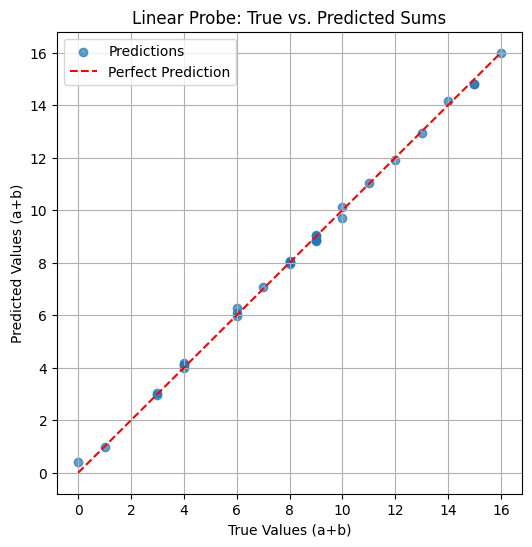

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 1. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_probe, y_probe, test_size=0.3, random_state=42 # Adjust test_size if needed
)

# 2. Initialize and train the Linear Regression model
probe_model = LinearRegression()
probe_model.fit(X_train, y_train)

# 3. Make predictions on the test set
y_pred = probe_model.predict(X_test)

# 4. Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Probe Performance:")
print(f"  Mean Squared Error (MSE): {mse:.4f}")
print(f"  R-squared (R2): {r2:.4f}")

# Optional: Basic baseline comparison (predicting the mean of training labels)
baseline_pred = np.full_like(y_test, y_train.mean())
baseline_mse = mean_squared_error(y_test, baseline_pred)
baseline_r2 = r2_score(y_test, baseline_pred) # Will be close to 0 by definition

print(f"\nBaseline Performance (Predicting Mean):")
print(f"  Baseline MSE: {baseline_mse:.4f}")
print(f"  Baseline R2: {baseline_r2:.4f}")


# Optional: Visualize predictions vs actual
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label='Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='Perfect Prediction')
plt.xlabel("True Values (a+b)")
plt.ylabel("Predicted Values (a+b)")
plt.title("Linear Probe: True vs. Predicted Sums")
plt.legend()
plt.grid(True)
plt.show()

The linear regression we've done is almost perfectly accurate, which means that the post-ReLU activations contain a linear representation of the target sum a+b. This means that the bulk of the computation is being done by the MLP. Hence, we can likely find 'sum neurons', i.e., neurons that are mostly responsible for implementing the computation. We will do this by correlation analysis: what neurons' activations correlate more strongly with a+b?

In [65]:
from scipy.stats import pearsonr

# Ensure inputs are numpy arrays
X_probe = np.asarray(X_probe)
y_probe = np.asarray(y_probe)

num_samples, d_mlp = X_probe.shape
neuron_sum_correlations = np.zeros(d_mlp)

# Calculate Pearson correlation for each neuron
for i in range(d_mlp):
    # pearsonr returns (correlation_coefficient, p_value)
    correlation, _ = pearsonr(X_probe[:, i], y_probe)
    neuron_sum_correlations[i] = correlation

# Handle potential NaN values if a neuron's activation was constant (zero variance)
neuron_sum_correlations = np.nan_to_num(neuron_sum_correlations)

print(f"Calculated correlations for {d_mlp} neurons.")
# The 'neuron_sum_correlations' array now holds the correlation of each neuron with a+b.

# Find the indices of neurons with highest absolute correlation
top_n = 140
# Get indices sorted by absolute correlation, descending
indices_sorted_by_abs_corr = np.argsort(np.abs(neuron_sum_correlations))[::-1]

print(f"\nTop {top_n} neurons by absolute correlation with sum (a+b):")
for i in range(top_n):
    idx = indices_sorted_by_abs_corr[i]
    print(f"  Neuron {idx}: Correlation = {neuron_sum_correlations[idx]:.4f}")

<ipython-input-65-047eae093e39>:13: ConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.



Calculated correlations for 512 neurons.

Top 140 neurons by absolute correlation with sum (a+b):
  Neuron 229: Correlation = 0.9463
  Neuron 240: Correlation = 0.9444
  Neuron 60: Correlation = 0.9444
  Neuron 363: Correlation = 0.9444
  Neuron 96: Correlation = 0.9444
  Neuron 372: Correlation = 0.9444
  Neuron 125: Correlation = 0.9444
  Neuron 79: Correlation = 0.9444
  Neuron 275: Correlation = 0.9443
  Neuron 215: Correlation = 0.9443
  Neuron 102: Correlation = 0.9443
  Neuron 128: Correlation = 0.9443
  Neuron 42: Correlation = 0.9443
  Neuron 251: Correlation = 0.9443
  Neuron 316: Correlation = 0.9443
  Neuron 397: Correlation = 0.9443
  Neuron 424: Correlation = 0.9443
  Neuron 340: Correlation = 0.9443
  Neuron 470: Correlation = 0.9443
  Neuron 37: Correlation = 0.9442
  Neuron 89: Correlation = 0.9442
  Neuron 223: Correlation = 0.9442
  Neuron 307: Correlation = 0.9442
  Neuron 85: Correlation = 0.9442
  Neuron 34: Correlation = 0.9433
  Neuron 407: Correlation = -0.9433

We observe widespread strong positive correlation of neuron activations with the target sum. In fact, more than 130 neurons have a correlation exceeding 0.9 with the target sum. This shows that the MLP represents the sum in a highly distributed manner. There aren't localized, specialized 'sum' neurons, per se.

We will now visualize the activation patterns of a few top-correlated neurons as heatmaps across the grid of all possible (a, b) input pairs. This reveals the specific function each of these top neurons computes according to input pairs. Hopefully from this we can hypothesize how they combine the principal components we identified earlier to achieve their strong correlation.

Generating activations for 3 neurons across 10x10 grid...
Activation generation complete.


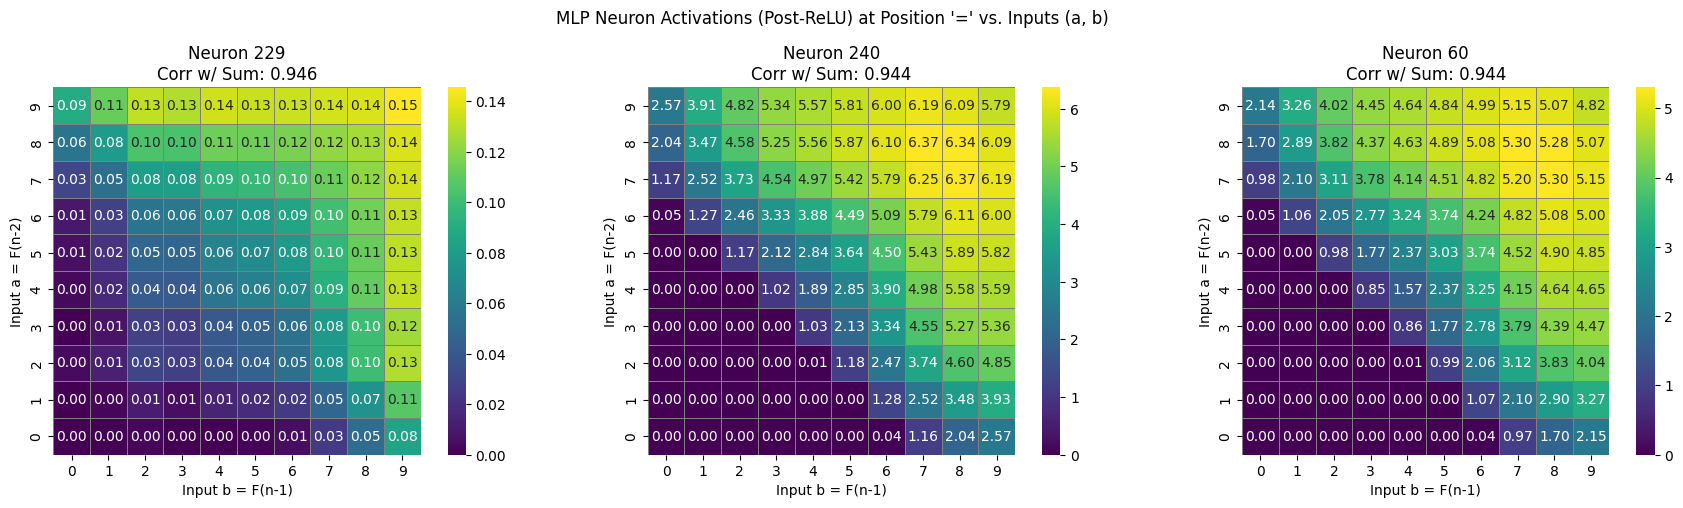

In [71]:
import seaborn as sns

equals_token_id = 10
N = 10
top_n_to_visualize = 3
top_neuron_indices = indices_sorted_by_abs_corr[:top_n_to_visualize]
mlp_hook_point_name = "blocks.0.mlp.hook_post" # Output AFTER ReLU

# --- Data Storage ---
# Create heatmaps initialized with NaN (or zero)
neuron_activation_heatmaps = {
    idx: np.full((N, N), np.nan) for idx in top_neuron_indices
}
captured_mlp_activation_storage = {} # Temporary storage during hook

# --- Hook Function ---
def capture_mlp_post_hook(activation: torch.Tensor, hook: 'HookPoint'):
    """Captures MLP activation at position 2."""
    captured_mlp_activation_storage['activation'] = activation[:, 2, :].detach().cpu()
    return activation

# --- Generate Activations ---
print(f"Generating activations for {top_n_to_visualize} neurons across {N}x{N} grid...")
model.eval() # Ensure model is in evaluation mode
with torch.no_grad(): # No need to track gradients
    for a in range(N):
        for b in range(N):
              input_tokens = torch.tensor([[a, b, equals_token_id]], dtype=torch.long)

              # Clear previous capture
              captured_mlp_activation_storage.clear()

              # Run with hook
              _ = model.run_with_hooks(
                  input_tokens,
                  fwd_hooks=[(mlp_hook_point_name, capture_mlp_post_hook)]
              )

              # Store the activations for the target neurons
              if 'activation' in captured_mlp_activation_storage:
                  full_activation_vector = captured_mlp_activation_storage['activation'][0] # Batch size 1
                  for neuron_idx in top_neuron_indices:
                      neuron_activation_heatmaps[neuron_idx][a, b] = full_activation_vector[neuron_idx].item()
print("Activation generation complete.")

# --- Plotting ---
fig, axes = plt.subplots(1, top_n_to_visualize, figsize=(6 * top_n_to_visualize, 5))
if top_n_to_visualize == 1: # Handle case of single subplot
    axes = [axes]

fig.suptitle("MLP Neuron Activations (Post-ReLU) at Position '=' vs. Inputs (a, b)")

for i, neuron_idx in enumerate(top_neuron_indices):
    ax = axes[i]
    heatmap_data = neuron_activation_heatmaps[neuron_idx]
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="viridis", ax=ax,
                linewidths=.5, linecolor='gray', cbar=True, square=True,
                # Mask cells with NaN so they don't show color
                mask=np.isnan(heatmap_data))
    ax.set_title(f"Neuron {neuron_idx}\nCorr w/ Sum: {neuron_sum_correlations[neuron_idx]:.3f}")
    ax.set_xlabel("Input b = F(n-1)")
    ax.set_ylabel("Input a = F(n-2)")
    # Set ticks to match input values
    ax.set_xticks(np.arange(N) + 0.5)
    ax.set_yticks(np.arange(N) + 0.5)
    ax.set_xticklabels(np.arange(N))
    ax.set_yticklabels(np.arange(N))
    ax.invert_yaxis() # Convention often puts (0,0) at top-left for matrices

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

The heatmaps show that the top-correlated neurons implement a function approximating ReLU(linear_function_of_sum). We observe a region of 0s (e.g., all values adding up to 6 or less for the middle neuron above), which is likely a result of the ReLU cutting off negatrive pre-activations, which basically creates a threshold below which the neurons do not fire. Further, we get roughly linear behavior with the sum of inputs above the threshold, as expected from the ReLU. The fact that the patterns are so similar across neurons again emphasizes that the computation implemented by the model is distributed.

We will now examine the pre-ReLU activations for these same neurons to test our hypothesis. If the core computation is indeed a linear function of the sum that is simply thresholded by ReLU, then the pre-ReLU heatmaps should reveal this underlying linear relationship more clearly across the entire input grid, without the large zeroed-out regions, thus confirming the thresholding mechanism.

Generating PRE-ReLU activations for 3 neurons across 10x10 grid...
PRE-ReLU activation generation complete.


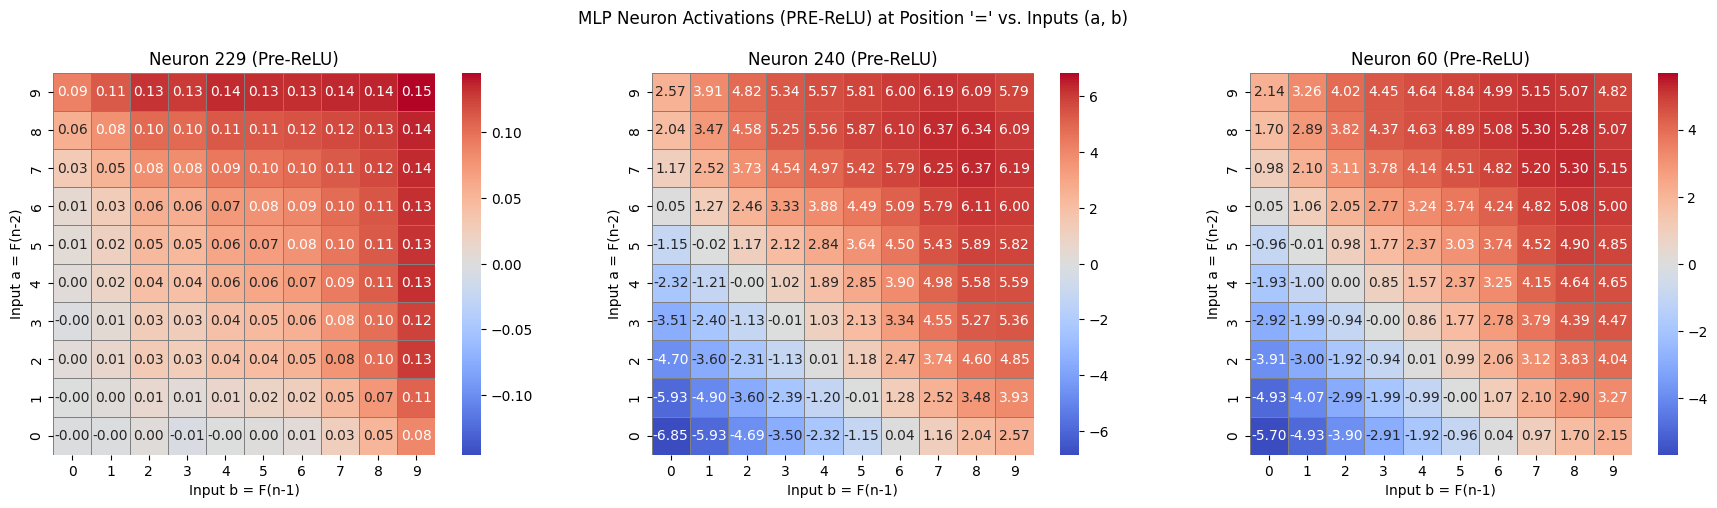

In [73]:
mlp_hook_point_name_pre = "blocks.0.mlp.hook_pre" # Input BEFORE ReLU

# --- Data Storage ---
neuron_pre_activation_heatmaps = {
    idx: np.full((N, N), np.nan) for idx in top_neuron_indices
}
captured_mlp_pre_activation_storage = {} # Temporary storage during hook

# --- Hook Function ---
def capture_mlp_pre_hook(activation: torch.Tensor, hook: 'HookPoint'):
    """Captures MLP activation input (before ReLU) at position 2."""
    captured_mlp_pre_activation_storage['activation'] = activation[:, 2, :].detach().cpu()
    return activation

# --- Generate Activations ---
print(f"Generating PRE-ReLU activations for {len(top_neuron_indices)} neurons across {N}x{N} grid...")
model.eval()
with torch.no_grad():
    for a in range(N):
        for b in range(N):
              input_tokens = torch.tensor([[a, b, equals_token_id]], dtype=torch.long)

              # Clear previous capture
              captured_mlp_pre_activation_storage.clear()

              # Run with PRE-ReLU hook
              _ = model.run_with_hooks(
                  input_tokens,
                  fwd_hooks=[(mlp_hook_point_name_pre, capture_mlp_pre_hook)]
              )

              # Store the activations for the target neurons
              if 'activation' in captured_mlp_pre_activation_storage:
                  full_activation_vector = captured_mlp_pre_activation_storage['activation'][0]
                  for neuron_idx in top_neuron_indices:
                      neuron_pre_activation_heatmaps[neuron_idx][a, b] = full_activation_vector[neuron_idx].item()
print("PRE-ReLU activation generation complete.")

# --- Plotting ---
fig, axes = plt.subplots(1, len(top_neuron_indices), figsize=(6 * len(top_neuron_indices), 5))
if len(top_neuron_indices) == 1: axes = [axes]

fig.suptitle("MLP Neuron Activations (PRE-ReLU) at Position '=' vs. Inputs (a, b)")

for i, neuron_idx in enumerate(top_neuron_indices):
    ax = axes[i]
    # Use a diverging colormap like 'coolwarm' or 'RdBu_r' for pre-ReLU
    # as values can be positive or negative. Center the color map at 0.
    heatmap_data = neuron_pre_activation_heatmaps[neuron_idx]
    max_abs_val = np.nanmax(np.abs(heatmap_data)) # Find max absolute value for symmetric color scale
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", ax=ax,
                linewidths=.5, linecolor='gray', cbar=True, square=True,
                mask=np.isnan(heatmap_data),
                vmin=-max_abs_val, vmax=max_abs_val) # Center colormap around 0
    ax.set_title(f"Neuron {neuron_idx} (Pre-ReLU)")
    ax.set_xlabel("Input b = F(n-1)")
    ax.set_ylabel("Input a = F(n-2)")
    ax.set_xticks(np.arange(N) + 0.5)
    ax.set_yticks(np.arange(N) + 0.5)
    ax.set_xticklabels(np.arange(N))
    ax.set_yticklabels(np.arange(N))
    ax.invert_yaxis()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

We in fact observe a linear relation between value of the sum and pre-ReLU neruon value. However, note that the top neuron has a lot of zero values, whereas the other two go from negative to positive with similar magnitude. This indicates that they learn different linear functions (slopes, biases). However, part of this difference is thresholded away by the ReLU activation.

We now want to fit the pre-ReLU values to the PCA components to understand exactly what function thereof they are computing.

In [79]:
import pandas as pd

target_neuron_idx = 240
feature_list = []
target_activation_list = []

# Ensure pca_scores is NumPy for easier indexing if needed, keep precision
pca_scores_np = pca_scores.detach().cpu().numpy().astype(np.float32)
pre_activation_target_neuron = neuron_pre_activation_heatmaps[target_neuron_idx] # Get the heatmap

for a in range(N):
    for b in range(N):
        if a + b < N: # Only use valid sums
            # Get pre-calculated pre-ReLU activation
            target_activation = pre_activation_target_neuron[a, b]

            # Ensure we don't include NaN values if any exist in heatmap
            if not np.isnan(target_activation):
                # Extract PCA features for a and b
                pc1_a = pca_scores_np[a, 0]
                pc2_a = pca_scores_np[a, 1]
                pc1_b = pca_scores_np[b, 0]
                pc2_b = pca_scores_np[b, 1]

                # Add more features if desired (e.g., interactions)
                # For now, just the 4 core PCA features
                features = [pc1_a, pc2_a, pc1_b, pc2_b]
                feature_list.append(features)
                target_activation_list.append(target_activation)

# Convert lists to NumPy arrays
X_features_for_neuron_model = np.array(feature_list, dtype=np.float32)
y_target_neuron_pre_activation = np.array(target_activation_list, dtype=np.float32)

# Define feature names for interpreting coefficients
feature_names = ['PC1(a)', 'PC2(a)', 'PC1(b)', 'PC2(b)']

print(f"Prepared data for modeling neuron {target_neuron_idx}:")
print(f"  X_features shape: {X_features_for_neuron_model.shape}")
print(f"  y_target shape: {y_target_neuron_pre_activation.shape}")

# --- Fit the Linear Regression Model ---
neuron_model = LinearRegression()
neuron_model.fit(X_features_for_neuron_model, y_target_neuron_pre_activation)

# --- Evaluate the fit ---
y_neuron_pred = neuron_model.predict(X_features_for_neuron_model)
r2_neuron_fit = r2_score(y_target_neuron_pre_activation, y_neuron_pred)

print(f"\nLinear Model Fit for Neuron {target_neuron_idx} (Pre-ReLU):")
print(f"  R-squared of fit: {r2_neuron_fit:.4f}")

# --- Interpret the model ---
print(f"  Learned coefficients:")
coeffs = pd.Series(neuron_model.coef_, index=feature_names)
print(coeffs)
print(f"  Intercept: {neuron_model.intercept_:.4f}")

Prepared data for modeling neuron 240:
  X_features shape: (55, 4)
  y_target shape: (55,)

Linear Model Fit for Neuron 240 (Pre-ReLU):
  R-squared of fit: 0.9894
  Learned coefficients:
PC1(a)   -2.089222
PC2(a)    0.182624
PC1(b)   -2.091087
PC2(b)    0.182149
dtype: float32
  Intercept: 3.1803


The excellent R² value confirms that Neuron 240's pre-ReLU activation is accurately modeled as a linear combination of the primary (linear value) and secondary (parabolic centrality) features derived from the input embeddings. The near-identical coefficients for the a and b components demonstrate symmetric treatment of the inputs, while the dominance of the PC1 coefficients confirms the neuron primarily computes a function proportional to the sum a+b. The smaller but non-zero PC2 coefficients suggest this core computation is subtly modulated based on the inputs' centrality, likely for fine-tuning or boundary adjustments within the N=10 range.

Something confuses me: it seems that the model just directly learns to add, as the linear component of the PCA is the most significant. However, the fact that there's a non-negligible contribution from the second component of the PCA makes me doubt this. In fact, the first one only explains 73% of the variance! That's a lot, but far from everything.

This motivates performing an ablation study, in which we get rid of the second principal component and investigate how (if at all) this affects model performance.

In [84]:
W_E_mean_gpu = W_E_mean.to(model.cfg.device) # Ensure mean is on correct device
pc1_vec = principal_components[0].to(model.cfg.device)
pc2_vec = principal_components[1].to(model.cfg.device)

# --- Squeeze the mean vector to be explicitly 1D ---
W_E_mean_1d_gpu = W_E_mean_gpu.squeeze(0) # Shape becomes [d_model]

def ablate_pc2_hook(
    activation: torch.Tensor, # Shape [batch, seq_len, d_model]
    hook: 'HookPoint'
):
    # Make a copy to modify
    ablated_activation = activation.clone()

    # Iterate through batch and relevant sequence positions (0 and 1 for a, b)
    for batch_idx in range(activation.shape[0]):
        for seq_idx in [0, 1]: # Ablate for token a and token b
            emb = activation[batch_idx, seq_idx, :] # Should be [d_model]

            # --- Subtract the squeezed 1D mean ---
            emb_centered = emb - W_E_mean_1d_gpu # Both are [d_model], result is [d_model]

            # Project - Now both inputs to torch.dot are 1D
            score_pc1 = torch.dot(emb_centered, pc1_vec)
            # score_pc2 = torch.dot(emb_centered, pc2_vec) # Still not needed

            # Reconstruct using only PC1 contribution
            # score_pc1 is a scalar, pc1_vec is [d_model] -> broadcasting works
            emb_centered_ablated = score_pc1 * pc1_vec

            # Add the 1D mean back
            emb_ablated = emb_centered_ablated + W_E_mean_1d_gpu

            # Put modified embedding back
            ablated_activation[batch_idx, seq_idx, :] = emb_ablated

    # Return the modified activations
    return ablated_activation

# --- How to run ---
embedding_hook_point = "hook_embed" # Or "hook_pos_embed", check model.hook_dict
logits = model.run_with_hooks(
     input_tokens,
     fwd_hooks=[(embedding_hook_point, ablate_pc2_hook)]
 )

test_pairs = []
test_labels_list = []
for a in range(N):
    for b in range(N):
          test_pairs.append([a, b, equals_token_id])
          test_labels_list.append(a + b)

# Convert to tensors
test_input_tokens = torch.tensor(test_pairs, dtype=torch.long).to(model.cfg.device)
test_labels = torch.tensor(test_labels_list, dtype=torch.long).to(model.cfg.device)

print(f"Created test data with {test_input_tokens.shape[0]} samples.")

# --- Helper function to calculate accuracy ---
def calculate_accuracy(logits, labels):
    """Calculates accuracy given logits and labels."""
    # Logits shape: [batch, seq_len, d_vocab]
    # We only care about the prediction at the last position (index 2)
    prediction_logits = logits[:, -1, :] # Shape: [batch, d_vocab]
    predicted_tokens = torch.argmax(prediction_logits, dim=-1) # Shape: [batch]
    correct_predictions = (predicted_tokens == labels).sum().item()
    total_predictions = labels.shape[0]
    accuracy = correct_predictions / total_predictions
    return accuracy, correct_predictions, total_predictions

# --- 2. Calculate Original Accuracy (No Hooks) ---
model.eval() # Set model to evaluation mode
with torch.no_grad(): # Use no_grad for inference efficiency
    original_logits = model(test_input_tokens)
    original_accuracy, orig_correct, orig_total = calculate_accuracy(original_logits, test_labels)

print(f"\nOriginal Model Performance:")
print(f"  Accuracy: {original_accuracy:.4f} ({orig_correct}/{orig_total})")

# --- 3. Calculate Ablated Accuracy (With Hook) ---
with torch.no_grad():
    ablated_logits = model.run_with_hooks(
        test_input_tokens,
        fwd_hooks=[(embedding_hook_point, ablate_pc2_hook)]
    )
    ablated_accuracy, ablated_correct, ablated_total = calculate_accuracy(ablated_logits, test_labels)

print(f"\nPC2 Ablated Model Performance:")
print(f"  Accuracy: {ablated_accuracy:.4f} ({ablated_correct}/{ablated_total})")

# --- 4. Compare ---
accuracy_drop = original_accuracy - ablated_accuracy
print(f"\nAccuracy Drop due to PC2 Ablation: {accuracy_drop:.4f}")

Created test data with 100 samples.

Original Model Performance:
  Accuracy: 1.0000 (100/100)

PC2 Ablated Model Performance:
  Accuracy: 0.4200 (42/100)

Accuracy Drop due to PC2 Ablation: 0.5800


Accuracy drops by a lot! We go from getting it right 100% of the time, to only 42%. So the second principal component is still very important, and whatever non-linearity it's doing actually matters. Let's now look specifically at which input pairs the model fails at when we ablate the PC2.

Found 58 failures after PC2 ablation:
    a  b  True Sum (a+b)  Predicted Sum (Ablated)
0   0  0               0                        3
1   0  1               1                        3
2   1  0               1                        3
3   0  2               2                        3
4   1  1               2                        3
5   2  0               2                        3
6   0  3               3                        4
7   3  0               3                        4
8   0  4               4                        5
9   2  2               4                        3
10  4  0               4                        5
11  0  5               5                        6
12  2  3               5                        4
13  3  2               5                        4
14  5  0               5                        6
15  0  6               6                        7
16  2  4               6                        5
17  3  3               6                        5
18  4  2    

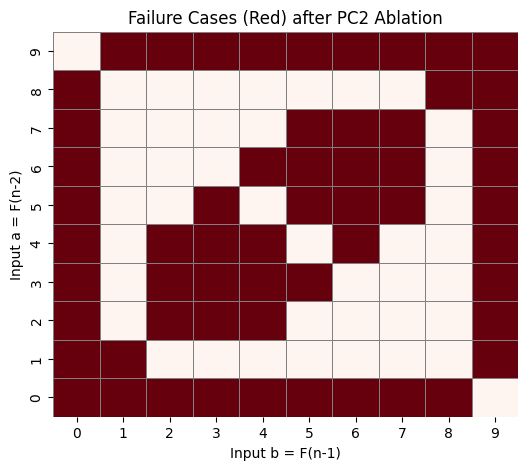

In [85]:
# --- Get predictions from the ablated run ---
ablated_logits_last_pos = ablated_logits[:, -1, :] # Shape: [num_samples, d_vocab]
ablated_predicted_tokens = torch.argmax(ablated_logits_last_pos, dim=-1) # Shape: [num_samples]

# --- Identify incorrect predictions ---
incorrect_mask = (ablated_predicted_tokens != test_labels)
incorrect_indices = torch.where(incorrect_mask)[0].cpu().numpy()

# --- Map indices back to (a, b) pairs ---
failing_pairs = []
original_a_values = test_input_tokens[:, 0].cpu().numpy()
original_b_values = test_input_tokens[:, 1].cpu().numpy()
true_sums = test_labels.cpu().numpy()
predicted_sums_ablated = ablated_predicted_tokens.cpu().numpy()

for idx in incorrect_indices:
    a = original_a_values[idx]
    b = original_b_values[idx]
    true_sum = true_sums[idx]
    predicted_sum = predicted_sums_ablated[idx]
    failing_pairs.append({
        'a': a,
        'b': b,
        'True Sum (a+b)': true_sum,
        'Predicted Sum (Ablated)': predicted_sum
    })

# --- Display the failing pairs ---
if not failing_pairs:
    print("No failures found after PC2 ablation (unexpected based on previous accuracy).")
else:
    print(f"Found {len(failing_pairs)} failures after PC2 ablation:")
    fail_df = pd.DataFrame(failing_pairs)
    # Sort for potentially easier pattern spotting
    fail_df = fail_df.sort_values(by=['True Sum (a+b)', 'a', 'b']).reset_index(drop=True)
    print(fail_df.to_string()) # Use to_string to print the full DataFrame

# Optional: Visualize failures on a heatmap
failure_heatmap = np.zeros((N, N))
for failure in failing_pairs:
    failure_heatmap[failure['a'], failure['b']] = 1 # Mark failures with 1

plt.figure(figsize=(6, 5))
sns.heatmap(failure_heatmap, cmap="Reds", linewidths=.5, linecolor='gray', cbar=False, annot=False)
plt.title("Failure Cases (Red) after PC2 Ablation")
plt.xlabel("Input b = F(n-1)")
plt.ylabel("Input a = F(n-2)")
plt.xticks(np.arange(N) + 0.5, np.arange(N))
plt.yticks(np.arange(N) + 0.5, np.arange(N))
plt.gca().invert_yaxis()
plt.show()

This is interesting... There's definitely patterns, but they are not easy to interpret. Some thoughts:

1.   Symmetry: Confirmed. Reinforces that a and b are treated symmetrically.
2.   Failures involving 0: This is a huge clue. The model fails for (0, 1) through (0, 8) and (1, 0) through (8, 0). However, it succeeds for (0, 0), (0, 9), and (9, 0).
3.   Same observation for failures involving 0. This suggests some symmetry in how the model treats small and big numbers.
3.   Central Failures: There's definitely a cluster of failures for pairs where both a and b are "mid-range" (roughly 2-7).

Given that the PC2 ablation dramatically impacts accuracy with a complex failure pattern—particularly affecting pairs involving edge tokens (0 and 9) differently and the central diagonal—it strongly suggests the issue lies not just in the MLP's internal calculation, but crucially in how the final output is derived from the MLP state. This points directly to the Unembedding layer (W_U), which performs this final mapping to output logits. Therefore, the next logical step is to analyze W_U to understand how it interprets the MLP's combined PC1/PC2 representation and why removing the PC2 component leads to these specific, non-uniform failures in decoding the sum.


### Looking at Activations

Helper variable:

In [ ]:
pattern_a = cache["pattern", 0, "attn"][:, :, -1, 0]
pattern_b = cache["pattern", 0, "attn"][:, :, -1, 1]
neuron_acts = cache["post", 0, "mlp"][:, -1, :]
neuron_pre_acts = cache["pre", 0, "mlp"][:, -1, :]

Get all shapes:

In [ ]:
for param_name, param in cache.items():
    print(param_name, param.shape)

In [ ]:
imshow(cache["pattern", 0].mean(dim=0)[:, -1, :], title="Average Attention Pattern per Head", xaxis="Source", yaxis="Head", x=['a', 'b', '='])

In [ ]:
imshow(cache["pattern", 0][5][:, -1, :], title="Average Attention Pattern per Head", xaxis="Source", yaxis="Head", x=['a', 'b', '='])

In [ ]:
dataset[:4]

In [ ]:
imshow(cache["pattern", 0][:, 0, -1, 0].reshape(p, p), title="Attention for Head 0 from a -> =", xaxis="b", yaxis="a")

In [ ]:
imshow(
    einops.rearrange(cache["pattern", 0][:, :, -1, 0], "(a b) head -> head a b", a=p, b=p),
    title="Attention for Head 0 from a -> =", xaxis="b", yaxis="a", facet_col=0)

Plotting neuron activations

In [ ]:
cache["post", 0, "mlp"].shape

In [ ]:
imshow(
    einops.rearrange(neuron_acts[:, :5], "(a b) neuron -> neuron a b", a=p, b=p),
    title="First 5 neuron acts", xaxis="b", yaxis="a", facet_col=0)

### Singular Value Decomposition

In [ ]:
W_E.shape


In [ ]:
U, S, Vh = torch.svd(W_E)
line(S, title="Singular Values")
imshow(U, title="Principal Components on the Input")

In [ ]:
# Control - random Gaussian matrix
U, S, Vh = torch.svd(torch.randn_like(W_E))
line(S, title="Singular Values Random")
imshow(U, title="Principal Components Random")

## Explaining Algorithm

### Analyse the Embedding - It's a Lookup Table!

In [ ]:
U, S, Vh = torch.svd(W_E)
line(U[:, :8].T, title="Principal Components of the embedding", xaxis="Input Vocabulary")

In [ ]:
fourier_basis = []
fourier_basis_names = []
fourier_basis.append(torch.ones(p))
fourier_basis_names.append("Constant")
for freq in range(1, p//2+1):
    fourier_basis.append(torch.sin(torch.arange(p)*2 * torch.pi * freq / p))
    fourier_basis_names.append(f"Sin {freq}")
    fourier_basis.append(torch.cos(torch.arange(p)*2 * torch.pi * freq / p))
    fourier_basis_names.append(f"Cos {freq}")
fourier_basis = torch.stack(fourier_basis, dim=0).to(device)
fourier_basis = fourier_basis/fourier_basis.norm(dim=-1, keepdim=True)
imshow(fourier_basis, xaxis="Input", yaxis="Component", y=fourier_basis_names)

In [ ]:
line(fourier_basis[:8], xaxis="Input", line_labels=fourier_basis_names[:8], title="First 8 Fourier Components")
line(fourier_basis[25:29], xaxis="Input", line_labels=fourier_basis_names[25:29], title="Middle Fourier Components")

In [ ]:
imshow(fourier_basis @ fourier_basis.T, title="All Fourier Vectors are Orthogonal")

### Analyse the Embedding

In [ ]:
imshow(fourier_basis @ W_E, yaxis="Fourier Component", xaxis="Residual Stream", y=fourier_basis_names, title="Embedding in Fourier Basis")

In [ ]:
line((fourier_basis @ W_E).norm(dim=-1), xaxis="Fourier Component", x=fourier_basis_names, title="Norms of Embedding in Fourier Basis")

In [ ]:
key_freqs = [17, 25, 32, 47]
key_freq_indices = [33, 34, 49, 50, 63, 64, 93, 94]
fourier_embed = fourier_basis @ W_E
key_fourier_embed = fourier_embed[key_freq_indices]
print("key_fourier_embed", key_fourier_embed.shape)
imshow(key_fourier_embed @ key_fourier_embed.T, title="Dot Product of embedding of key Fourier Terms")

### Key Frequencies

In [ ]:
line(fourier_basis[[34, 50, 64, 94]], title="Cos of key freqs", line_labels=[34, 50, 64, 94])

In [ ]:
line(fourier_basis[[34, 50, 64, 94]].mean(0), title="Constructive Interference")

## Analyse Neurons

In [ ]:
imshow(
    einops.rearrange(neuron_acts[:, :5], "(a b) neuron -> neuron a b", a=p, b=p),
    title="First 5 neuron acts", xaxis="b", yaxis="a", facet_col=0)

In [ ]:
imshow(
    einops.rearrange(neuron_acts[:, 0], "(a b) -> a b", a=p, b=p),
    title="First neuron act", xaxis="b", yaxis="a",)

In [ ]:
imshow(fourier_basis[94][None, :] * fourier_basis[94][:, None], title="Cos 47a * cos 47b")

In [ ]:
imshow(fourier_basis[94][None, :] * fourier_basis[0][:, None], title="Cos 47a * const")

In [ ]:
imshow(fourier_basis @ neuron_acts[:, 0].reshape(p, p) @ fourier_basis.T, title="2D Fourier Transformer of neuron 0", xaxis="b", yaxis="a", x=fourier_basis_names, y=fourier_basis_names)

In [ ]:
imshow(fourier_basis @ neuron_acts[:, 5].reshape(p, p) @ fourier_basis.T, title="2D Fourier Transformer of neuron 5", xaxis="b", yaxis="a", x=fourier_basis_names, y=fourier_basis_names)

In [ ]:
imshow(fourier_basis @ torch.randn_like(neuron_acts[:, 0]).reshape(p, p) @ fourier_basis.T, title="2D Fourier Transformer of RANDOM", xaxis="b", yaxis="a", x=fourier_basis_names, y=fourier_basis_names)

### Neuron Clusters

In [ ]:
fourier_neuron_acts = fourier_basis @ einops.rearrange(neuron_acts, "(a b) neuron -> neuron a b", a=p, b=p) @ fourier_basis.T
# Center these by removing the mean - doesn't matter!
fourier_neuron_acts[:, 0, 0] = 0.
print("fourier_neuron_acts", fourier_neuron_acts.shape)

In [ ]:
neuron_freq_norm = torch.zeros(p//2, model.cfg.d_mlp).to(device)
for freq in range(0, p//2):
    for x in [0, 2*(freq+1) - 1, 2*(freq+1)]:
        for y in [0, 2*(freq+1) - 1, 2*(freq+1)]:
            neuron_freq_norm[freq] += fourier_neuron_acts[:, x, y]**2
neuron_freq_norm = neuron_freq_norm / fourier_neuron_acts.pow(2).sum(dim=[-1, -2])[None, :]
imshow(neuron_freq_norm, xaxis="Neuron", yaxis="Freq", y=torch.arange(1, p//2+1), title="Neuron Frac Explained by Freq")

In [ ]:
line(neuron_freq_norm.max(dim=0).values.sort().values, xaxis="Neuron", title="Max Neuron Frac Explained over Freqs")

## Read Off the Neuron-Logit Weights to Interpret

In [ ]:
W_logit = model.blocks[0].mlp.W_out @ model.unembed.W_U
print("W_logit", W_logit.shape)

In [ ]:
line((W_logit @ fourier_basis.T).norm(dim=0), x=fourier_basis_names, title="W_logit in the Fourier Basis")

In [ ]:
neurons_17 = neuron_freq_norm[17-1]>0.85
neurons_17.shape

In [ ]:
neurons_17.sum()

In [ ]:
line((W_logit[neurons_17] @ fourier_basis.T).norm(dim=0), x=fourier_basis_names, title="W_logit for freq 17 neurons in the Fourier Basis")

Study sin 17

In [ ]:
freq = 17
W_logit_fourier = W_logit @ fourier_basis
neurons_sin_17 = W_logit_fourier[:, 2*freq-1]
line(neurons_sin_17)

In [ ]:
neuron_acts.shape

In [ ]:
inputs_sin_17c = neuron_acts @ neurons_sin_17
imshow(fourier_basis @ inputs_sin_17c.reshape(p, p) @ fourier_basis.T, title="Fourier Heatmap over inputs for sin17c", x=fourier_basis_names, y=fourier_basis_names)

# Black Box Methods + Progress Measures

## Setup Code

Code to plot embedding freqs

In [ ]:
def embed_to_cos_sin(fourier_embed):
    if len(fourier_embed.shape) == 1:
        return torch.stack([fourier_embed[1::2], fourier_embed[2::2]])
    else:
        return torch.stack([fourier_embed[:, 1::2], fourier_embed[:, 2::2]], dim=1)

from neel_plotly.plot import melt

def plot_embed_bars(
    fourier_embed,
    title="Norm of embedding of each Fourier Component",
    return_fig=False,
    **kwargs
):
    cos_sin_embed = embed_to_cos_sin(fourier_embed)
    df = melt(cos_sin_embed)
    # display(df)
    group_labels = {0: "sin", 1: "cos"}
    df["Trig"] = df["0"].map(lambda x: group_labels[x])
    fig = px.bar(
        df,
        barmode="group",
        color="Trig",
        x="1",
        y="value",
        labels={"1": "$w_k$", "value": "Norm"},
        title=title,
        **kwargs
    )
    fig.update_layout(dict(legend_title=""))

    if return_fig:
        return fig
    else:
        fig.show()

Code to test a tensor of edited logits

In [ ]:
def test_logits(logits, bias_correction=False, original_logits=None, mode="all"):
    # Calculates cross entropy loss of logits representing a batch of all p^2
    # possible inputs
    # Batch dimension is assumed to be first
    if logits.shape[1] == p * p:
        logits = logits.T
    if logits.shape == torch.Size([p * p, p + 1]):
        logits = logits[:, :-1]
    logits = logits.reshape(p * p, p)
    if bias_correction:
        # Applies bias correction - we correct for any missing bias terms,
        # independent of the input, by centering the new logits along the batch
        # dimension, and then adding the average original logits across all inputs
        logits = (
            einops.reduce(original_logits - logits, "batch ... -> ...", "mean") + logits
        )
    if mode == "train":
        return loss_fn(logits[train_indices], labels[train_indices])
    elif mode == "test":
        return loss_fn(logits[test_indices], labels[test_indices])
    elif mode == "all":
        return loss_fn(logits, labels)

Code to run a metric over every checkpoint

In [ ]:
metric_cache = {}

In [ ]:
def get_metrics(model, metric_cache, metric_fn, name, reset=False):
    if reset or (name not in metric_cache) or (len(metric_cache[name]) == 0):
        metric_cache[name] = []
        for c, sd in enumerate(tqdm.tqdm((model_checkpoints))):
            model.reset_hooks()
            model.load_state_dict(sd)
            out = metric_fn(model)
            if type(out) == torch.Tensor:
                out = utils.to_numpy(out)
            metric_cache[name].append(out)
        model.load_state_dict(model_checkpoints[-1])
        try:
            metric_cache[name] = torch.tensor(metric_cache[name])
        except:
            metric_cache[name] = torch.tensor(np.array(metric_cache[name]))



## Defining Progress Measures

### Loss Curves

In [ ]:
memorization_end_epoch = 1500
circuit_formation_end_epoch = 13300
cleanup_end_epoch = 16600

In [ ]:
def add_lines(figure):
    figure.add_vline(memorization_end_epoch, line_dash="dash", opacity=0.7)
    figure.add_vline(circuit_formation_end_epoch, line_dash="dash", opacity=0.7)
    figure.add_vline(cleanup_end_epoch, line_dash="dash", opacity=0.7)
    return figure

In [ ]:
fig = line([train_losses[::100], test_losses[::100]], x=np.arange(0, len(train_losses), 100), xaxis="Epoch", yaxis="Loss", log_y=True, title="Training Curve for Modular Addition", line_labels=['train', 'test'], toggle_x=True, toggle_y=True, return_fig=True)
add_lines(fig)

### Logit Periodicity

In [ ]:
all_logits = original_logits[:, -1, :]
print(all_logits.shape)
all_logits = einops.rearrange(all_logits, "(a b) c -> a b c", a=p, b=p)
print(all_logits.shape)

In [ ]:
coses = {}
for freq in key_freqs:
    print("Freq:", freq)
    a = torch.arange(p)[:, None, None]
    b = torch.arange(p)[None, :, None]
    c = torch.arange(p)[None, None, :]
    cube_predicted_logits = torch.cos(freq * 2 * torch.pi / p * (a + b - c)).to(device)
    cube_predicted_logits /= cube_predicted_logits.norm()
    coses[freq] = cube_predicted_logits

In [ ]:
approximated_logits = torch.zeros_like(all_logits)
for freq in key_freqs:
    print("Freq:", freq)
    coeff = (all_logits * coses[freq]).sum()
    print("Coeff:", coeff)
    cosine_sim = coeff / all_logits.norm()
    print("Cosine Sim:", cosine_sim)
    approximated_logits += coeff * coses[freq]
residual = all_logits - approximated_logits
print("Residual size:", residual.norm())
print("Residual fraction of norm:", residual.norm()/all_logits.norm())

In [ ]:
random_logit_cube = torch.randn_like(all_logits)
print((all_logits * random_logit_cube).sum()/random_logit_cube.norm()/all_logits.norm())

In [ ]:
test_logits(all_logits)

In [ ]:
test_logits(approximated_logits)

#### Look During Training

In [ ]:
cos_cube = []
for freq in range(1, p//2 + 1):
    a = torch.arange(p)[:, None, None]
    b = torch.arange(p)[None, :, None]
    c = torch.arange(p)[None, None, :]
    cube_predicted_logits = torch.cos(freq * 2 * torch.pi / p * (a + b - c)).to(device)
    cube_predicted_logits /= cube_predicted_logits.norm()
    cos_cube.append(cube_predicted_logits)
cos_cube = torch.stack(cos_cube, dim=0)
print(cos_cube.shape)

In [ ]:
def get_cos_coeffs(model):
    logits = model(dataset)[:, -1]
    logits = einops.rearrange(logits, "(a b) c -> a b c", a=p, b=p)
    vals = (cos_cube * logits[None, :, :, :]).sum([-3, -2, -1])
    return vals


get_metrics(model, metric_cache, get_cos_coeffs, "cos_coeffs")
print(metric_cache["cos_coeffs"].shape)

In [ ]:
fig = line(metric_cache["cos_coeffs"].T, line_labels=[f"Freq {i}" for i in range(1, p//2+1)], title="Coefficients with Predicted Logits", xaxis="Epoch", x=checkpoint_epochs, yaxis="Coefficient", return_fig=True)
add_lines(fig)

In [ ]:
def get_cos_sim(model):
    logits = model(dataset)[:, -1]
    logits = einops.rearrange(logits, "(a b) c -> a b c", a=p, b=p)
    vals = (cos_cube * logits[None, :, :, :]).sum([-3, -2, -1])
    return vals / logits.norm()

get_metrics(model, metric_cache, get_cos_sim, "cos_sim") # You may need a big GPU. If you don't have one and can't work around this, raise an issue for help!
print(metric_cache["cos_sim"].shape)

fig = line(metric_cache["cos_sim"].T, line_labels=[f"Freq {i}" for i in range(1, p//2+1)], title="Cosine Sim with Predicted Logits", xaxis="Epoch", x=checkpoint_epochs, yaxis="Cosine Sim", return_fig=True)
add_lines(fig)

In [ ]:
def get_residual_cos_sim(model):
    logits = model(dataset)[:, -1]
    logits = einops.rearrange(logits, "(a b) c -> a b c", a=p, b=p)
    vals = (cos_cube * logits[None, :, :, :]).sum([-3, -2, -1])
    residual = logits - (vals[:, None, None, None] * cos_cube).sum(dim=0)
    return residual.norm() / logits.norm()

get_metrics(model, metric_cache, get_residual_cos_sim, "residual_cos_sim")
print(metric_cache["residual_cos_sim"].shape)

fig = line([metric_cache["cos_sim"][:, i] for i in range(p//2)]+[metric_cache["residual_cos_sim"]], line_labels=[f"Freq {i}" for i in range(1, p//2+1)]+["residual"], title="Cosine Sim with Predicted Logits + Residual", xaxis="Epoch", x=checkpoint_epochs, yaxis="Cosine Sim", return_fig=True)
add_lines(fig)

## Restricted Loss

In [ ]:
neuron_acts.shape

In [ ]:
neuron_acts_square = einops.rearrange(neuron_acts, "(a b) neur -> a b neur", a=p, b=p).clone()
# Center it
neuron_acts_square -= einops.reduce(neuron_acts_square, "a b neur -> 1 1 neur", "mean")
neuron_acts_square_fourier = einsum("a b neur, fa a, fb b -> fa fb neur", neuron_acts_square, fourier_basis, fourier_basis)
imshow(neuron_acts_square_fourier.norm(dim=-1), xaxis="Fourier Component b", yaxis="Fourier Component a", title="Norms of neuron activations by Fourier Component", x=fourier_basis_names, y=fourier_basis_names)

In [ ]:
original_logits, cache = model.run_with_cache(dataset)
print(original_logits.numel())
neuron_acts = cache["post", 0, "mlp"][:, -1, :]

In [ ]:
approx_neuron_acts = torch.zeros_like(neuron_acts)
approx_neuron_acts += neuron_acts.mean(dim=0)
a = torch.arange(p)[:, None]
b = torch.arange(p)[None, :]
for freq in key_freqs:
    cos_apb_vec = torch.cos(freq * 2 * torch.pi / p * (a + b)).to(device)
    cos_apb_vec /= cos_apb_vec.norm()
    cos_apb_vec = einops.rearrange(cos_apb_vec, "a b -> (a b) 1")
    approx_neuron_acts += (neuron_acts * cos_apb_vec).sum(dim=0) * cos_apb_vec
    sin_apb_vec = torch.sin(freq * 2 * torch.pi / p * (a + b)).to(device)
    sin_apb_vec /= sin_apb_vec.norm()
    sin_apb_vec = einops.rearrange(sin_apb_vec, "a b -> (a b) 1")
    approx_neuron_acts += (neuron_acts * sin_apb_vec).sum(dim=0) * sin_apb_vec
restricted_logits = approx_neuron_acts @ W_logit
print(loss_fn(restricted_logits[test_indices], test_labels))

In [ ]:
print(loss_fn(all_logits, labels)) # This bugged on models not fully trained

### Look During Training

In [ ]:
def get_restricted_loss(model):
    logits, cache = model.run_with_cache(dataset)
    logits = logits[:, -1, :]
    neuron_acts = cache["post", 0, "mlp"][:, -1, :]
    approx_neuron_acts = torch.zeros_like(neuron_acts)
    approx_neuron_acts += neuron_acts.mean(dim=0)
    a = torch.arange(p)[:, None]
    b = torch.arange(p)[None, :]
    for freq in key_freqs:
        cos_apb_vec = torch.cos(freq * 2 * torch.pi / p * (a + b)).to(device)
        cos_apb_vec /= cos_apb_vec.norm()
        cos_apb_vec = einops.rearrange(cos_apb_vec, "a b -> (a b) 1")
        approx_neuron_acts += (neuron_acts * cos_apb_vec).sum(dim=0) * cos_apb_vec
        sin_apb_vec = torch.sin(freq * 2 * torch.pi / p * (a + b)).to(device)
        sin_apb_vec /= sin_apb_vec.norm()
        sin_apb_vec = einops.rearrange(sin_apb_vec, "a b -> (a b) 1")
        approx_neuron_acts += (neuron_acts * sin_apb_vec).sum(dim=0) * sin_apb_vec
    restricted_logits = approx_neuron_acts @ model.blocks[0].mlp.W_out @ model.unembed.W_U
    # Add bias term
    restricted_logits += logits.mean(dim=0, keepdim=True) - restricted_logits.mean(dim=0, keepdim=True)
    return loss_fn(restricted_logits[test_indices], test_labels)
get_restricted_loss(model)

In [ ]:
get_metrics(model, metric_cache, get_restricted_loss, "restricted_loss", reset=True)
print(metric_cache["restricted_loss"].shape)

In [ ]:
fig = line([train_losses[::100], test_losses[::100], metric_cache["restricted_loss"]], x=np.arange(0, len(train_losses), 100), xaxis="Epoch", yaxis="Loss", log_y=True, title="Restricted Loss Curve", line_labels=['train', 'test', "restricted_loss"], toggle_x=True, toggle_y=True, return_fig=True)
add_lines(fig)

In [ ]:
fig = line([torch.tensor(test_losses[::100])/metric_cache["restricted_loss"]], x=np.arange(0, len(train_losses), 100), xaxis="Epoch", yaxis="Loss", log_y=True, title="Restricted Loss to Test Loss Ratio", toggle_x=True, toggle_y=True, return_fig=True)
# WARNING: bugged when cancelling training half way thr ough
add_lines(fig)

## Excluded Loss

In [ ]:
approx_neuron_acts = torch.zeros_like(neuron_acts)
# approx_neuron_acts += neuron_acts.mean(dim=0)
a = torch.arange(p)[:, None]
b = torch.arange(p)[None, :]
for freq in key_freqs:
    cos_apb_vec = torch.cos(freq * 2 * torch.pi / p * (a + b)).to(device)
    cos_apb_vec /= cos_apb_vec.norm()
    cos_apb_vec = einops.rearrange(cos_apb_vec, "a b -> (a b) 1")
    approx_neuron_acts += (neuron_acts * cos_apb_vec).sum(dim=0) * cos_apb_vec
    sin_apb_vec = torch.sin(freq * 2 * torch.pi / p * (a + b)).to(device)
    sin_apb_vec /= sin_apb_vec.norm()
    sin_apb_vec = einops.rearrange(sin_apb_vec, "a b -> (a b) 1")
    approx_neuron_acts += (neuron_acts * sin_apb_vec).sum(dim=0) * sin_apb_vec
excluded_neuron_acts = neuron_acts - approx_neuron_acts
excluded_logits = excluded_neuron_acts @ W_logit
print(loss_fn(excluded_logits[train_indices], train_labels))

In [ ]:
def get_excluded_loss(model):
    logits, cache = model.run_with_cache(dataset)
    logits = logits[:, -1, :]
    neuron_acts = cache["post", 0, "mlp"][:, -1, :]
    approx_neuron_acts = torch.zeros_like(neuron_acts)
    # approx_neuron_acts += neuron_acts.mean(dim=0)
    a = torch.arange(p)[:, None]
    b = torch.arange(p)[None, :]
    for freq in key_freqs:
        cos_apb_vec = torch.cos(freq * 2 * torch.pi / p * (a + b)).to(device)
        cos_apb_vec /= cos_apb_vec.norm()
        cos_apb_vec = einops.rearrange(cos_apb_vec, "a b -> (a b) 1")
        approx_neuron_acts += (neuron_acts * cos_apb_vec).sum(dim=0) * cos_apb_vec
        sin_apb_vec = torch.sin(freq * 2 * torch.pi / p * (a + b)).to(device)
        sin_apb_vec /= sin_apb_vec.norm()
        sin_apb_vec = einops.rearrange(sin_apb_vec, "a b -> (a b) 1")
        approx_neuron_acts += (neuron_acts * sin_apb_vec).sum(dim=0) * sin_apb_vec
    excluded_neuron_acts = neuron_acts - approx_neuron_acts
    residual_stream_final = excluded_neuron_acts @ model.blocks[0].mlp.W_out + cache["resid_mid", 0][:, -1, :]
    excluded_logits = residual_stream_final @ model.unembed.W_U
    return loss_fn(excluded_logits[train_indices], train_labels)
get_excluded_loss(model)

In [ ]:
get_metrics(model, metric_cache, get_excluded_loss, "excluded_loss", reset=True)
print(metric_cache["excluded_loss"].shape)

In [ ]:
fig = line([train_losses[::100], test_losses[::100], metric_cache["excluded_loss"], metric_cache["restricted_loss"]], x=np.arange(0, len(train_losses), 100), xaxis="Epoch", yaxis="Loss", log_y=True, title="Excluded and Restricted Loss Curve", line_labels=['train', 'test', "excluded_loss", "restricted_loss"], toggle_x=True, toggle_y=True, return_fig=True)

add_lines(fig)